# Residual U-Net Train

This notebook trains a residual U-Net model for enhanced JPEG reconstruction.

Details:
- On the fly data augmentation
- JPEG quality varying between 10-20

In [1]:
! sudo pip3 install --upgrade pip; sudo pip3 install keras --upgrade

The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
    100% |████████████████████████████████| 1.4MB 26.8MB/s ta 0:00:01
  Found existing installation: pip 18.1
    Uninstalling pip-18.1:
      Successfully uninstalled pip-18.1
The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip' or its parent directory is not owned by 

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from skimage.util import random_noise, img_as_ubyte

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
from models import unet, my_unet

Using TensorFlow backend.


In [3]:
! pip install --upgrade pip;  pip install nibabel scikit-image

  Using cached https://files.pythonhosted.org/packages/d8/f3/413bab4ff08e1fc4828dfc59996d721917df8e8583ea85385d51125dceff/pip-19.0.3-py2.py3-none-any.whl
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
  Using cached https://files.pythonhosted.org/packages/0a/36/a9e7ef516d0f63c2610c0033daf06c1001b1b70943f08c89d502c19bedf6/nibabel-2.3.3-py3-none-any.whl


# Pre-Training

Using ImageNet Data: ILSVRC2015_DET_test_new

Testing: 7000
Validation: 3000

In [4]:
#import resize_by_pad_or_crop as rsz
from math import ceil, floor

def resize_by_pad_or_crop(img, sz=[256,256], padVal=0):
    X,Y = img.shape

    offx = abs(sz[0] - X)/2
    offy = abs(sz[1] - Y)/2

    #print (X, Y)
    #print (offx, offy)

    tmpx = np.zeros((sz[0], Y), dtype=np.uint8) + padVal
    if X < sz[0]:
        tmpx[floor(offx):-ceil(offx),:] = img[:,:];
    elif X > sz[0]:
        tmpx[:,:] = img[floor(offx):-ceil(offx),:];
    else:
        tmpx[:,:] = img[:,:]

    tmpy = np.zeros((sz[0], sz[1]), dtype=np.uint8) + padVal
    if Y < sz[1]:
        tmpy[:,floor(offy):-ceil(offy)] = tmpx[:,:];
    elif Y > sz[1]:
        tmpy[:,:] = tmpx[:,floor(offy):-ceil(offy)];
    else:
        tmpy[:,:] = tmpx[:,:]
        
    return tmpy

pretrain_path = "/home/ubuntu/volume1/Kevin/pretrain/train/*.JPEG"
preval_path = "/home/ubuntu/volume1/Kevin/pretrain/val/*.JPEG" 

pretrain_images = glob.glob(pretrain_path)
preval_images = glob.glob(preval_path)

# Summary of images
print("Pre-train set size:", len(pretrain_images))
print("Pre-validation set size:", len(preval_images))

H,W = 256, 256
norm = 255.0
compr_range = (10,20)

pretrain_unc = np.zeros((len(pretrain_images),H,W,1),dtype = np.float32)

# Train set
for ii in range(len(pretrain_images)):
    # Load uncompressed image
    im1 = Image.open(pretrain_images[ii])
    im1 = im1.convert('L')
    pretrain_unc[ii,:,:,0] = resize_by_pad_or_crop(np.array(im1), sz=[H,W])

# Validation set
preval_unc = np.zeros((len(preval_images),H,W,1),dtype = np.float32)
preval_compr = preval_unc.copy()
precompr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(preval_images),replace = True)

for ii in range(len(preval_images)):
    # Load uncompressed image
    im1 = Image.open(preval_images[ii])
    im1 = im1.convert('L')
    preval_unc[ii,:,:,0] = resize_by_pad_or_crop(np.array(im1), sz=[H,W])

    # JPEG compress the image    
    buffer = io.BytesIO()
    im1.save(buffer, "JPEG", quality=int(precompr_val[ii]))
    im2 = Image.open(buffer)
    im2 = im2.convert('L')
    preval_compr[ii,:,:,0] = resize_by_pad_or_crop(np.array(im2), sz=[H,W])
    
preval_unc /= norm
preval_compr /= norm

#plt.imshow(pretrain_unc[ii,:,:,0], cmap='gray')

Pre-train set size: 7000
Pre-validation set size: 3000


In [5]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_unet_data_augmentation_compress_10_20_pretrain.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = unet(input_size = (256 ,256 ,1),drop = 0.0,residual = True)
model.compile(loss = "mse",optimizer=opt)

(8, 256, 256, 1)
0.0 1.0
0.0 1.0


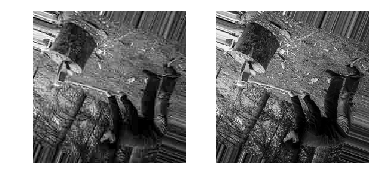

In [6]:
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(pretrain_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(pretrain_unc,batch_size = batch_size,seed = seed)

def combine_generator(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               batch_unc.shape[0],replace = True)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2)
        yield(batch_comp/255.0, batch_unc/255.0)

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,compr_range)


# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray')
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray')
    plt.axis("off")
    plt.show()
    break

In [ ]:
prehist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=pretrain_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (preval_compr,preval_unc),
                 callbacks=[checkpoint,earlyStopping])

Epoch 1/30
 45/875 [>.............................] - ETA: 19:24 - loss: 48.7186

In [ ]:
#Saving training history
np.save("../Data/loss_residual_unet_data_augmentation_compress_10_20_pretrain.npy",np.array(prehist.history['loss']))
np.save("../Data/val_loss_residual_unet_data_augmentation_compress_10_20_pretrain.npy",np.array(prehist.history['val_loss']))

preloss = np.array(prehist.history['loss'])
preval_loss = np.array(prehist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(preloss,'x-', markersize = 4,label = "Train")
plt.plot(preval_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# MR Dataset Training

In [2]:
# Train and validation data paths
train_path = "/home/ubuntu/volume1/TIFF/Development/Training/*.tif"
val_path = "/home/ubuntu/volume1/TIFF/Development/Validation/*.tif"

# Listing train and validation images
train_images = glob.glob(train_path)
val_images = glob.glob(val_path)

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))

Train set size: 10740
Validation set size: 5370


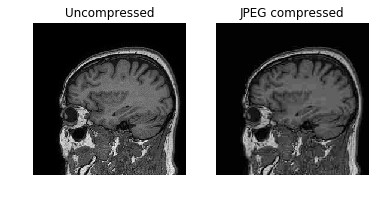

In [3]:
# Load uncompressed image
im1 = Image.open(train_images[300])
im1_array = np.array(im1)

# im1_noise_array = random_noise(im1_array, mode='s&p')
# im1_noise_array = img_as_ubyte(im1_noise_array)
# im1_noise = Image.fromarray(im1_noise_array, mode='L')

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# buffer2 = io.BytesIO()
# im1_noise.save(buffer2, "JPEG", quality=15)
# im2_noise = Image.open(buffer2)
# im2_noise_array = np.array(im2_noise)

# Display the images
plt.figure()
plt.subplot(1,2,1)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(1,2,2)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
# plt.subplot(143)
# plt.imshow(im1_noise_array,cmap = "gray")
# plt.axis("off")
# plt.title("Uncompr + Gauss Noise")
# plt.subplot(144)
# plt.imshow(im2_noise_array,cmap = "gray")
# plt.axis("off")
# plt.title("Uncompr + Gauss Noise Compressed")
plt.show()

In [4]:
H,W = 256, 256
norm = 255.0
compr_range = (5,6)

useNoise = False

train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)


# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    
    im1_array = np.array(im1)

    #inject noise (s&p)
    if useNoise:
        im1_array = random_noise(im1_array, mode='s&p')
        im1_array = img_as_ubyte(im1_array)
        
    train_unc[ii,:,:,0] = im1_array

# Validation set
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
val_compr = val_unc.copy()

if compr_range[0] != compr_range[1]:
    compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)
else:
    compr_val = np.zeros(len(val_images)) + compr_range[0] # note: compr_val is a float

for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1)

    # JPEG compress the image    
    buffer = io.BytesIO()
    im1.save(buffer, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buffer)
    val_compr[ii,:,:,0] = np.array(im2)
    
val_unc /= norm
val_compr /= norm

Validation set


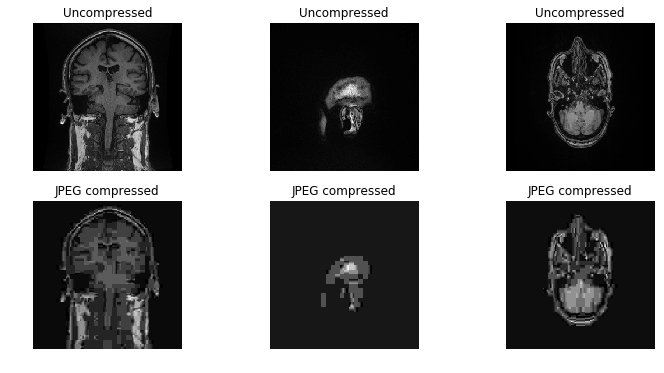

In [5]:
indexes_val = np.arange(len(val_images),dtype = int)
np.random.shuffle(indexes_val)
indexes_val = indexes_val[:3]

print("Validation set")
plt.figure(figsize = (12,6))
for ii in range(3):
    plt.subplot(2,3,ii+1)
    plt.imshow(val_unc[indexes_val[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed")
    plt.subplot(2,3,ii + 4)
    plt.imshow(val_compr[indexes_val[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("JPEG compressed")
plt.show()    


In [6]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_unet_data_augmentation_compress_5.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


# opt = Adam(lr=0.0001)
# model = unet(input_size = (256 ,256 ,1),drop = 0.0,residual = True)
# model.compile(loss = "mse",optimizer=opt)

opt = Adam(lr=0.0001)
model = my_unet()
model.compile(loss = "mse",optimizer=opt)

# Use pre-train network
model.load_weights("../Models/residual_unet_data_augmentation_imagenet_compress_16_20.hdf5")

(8, 256, 256, 1)
0.0 1.0
0.0 0.8490093


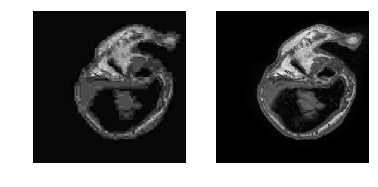

In [7]:
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

def combine_generator(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        
        if compr_range[0] != compr_range[1]:
            compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               batch_unc.shape[0],replace = True)
        else:
            compr = np.zeros(batch_unc.shape[0]) + compr_range[0] # note: compr is a float

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2)
        yield(batch_comp/255.0, batch_unc/255.0)

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,compr_range)


# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray')
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray')
    plt.axis("off")
    plt.show()
    break

In [8]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

Epoch 1/30
1343/1342 [==============================] - 132s 99ms/step - loss: 8.0413e-04 - val_loss: 0.0011
Epoch 2/30
1343/1342 [==============================] - 129s 96ms/step - loss: 7.7691e-04 - val_loss: 0.0011
Epoch 3/30
1343/1342 [==============================] - 128s 96ms/step - loss: 7.6888e-04 - val_loss: 0.0011
Epoch 4/30
1343/1342 [==============================] - 129s 96ms/step - loss: 7.6365e-04 - val_loss: 0.0011
Epoch 5/30
1343/1342 [==============================] - 129s 96ms/step - loss: 7.6105e-04 - val_loss: 0.0011
Epoch 6/30
1343/1342 [==============================] - 128s 96ms/step - loss: 7.5830e-04 - val_loss: 0.0011
Epoch 7/30
1343/1342 [==============================] - 128s 96ms/step - loss: 7.5580e-04 - val_loss: 0.0011
Epoch 8/30
1343/1342 [==============================] - 128s 96ms/step - loss: 7.5347e-04 - val_loss: 0.0011
Epoch 9/30
1343/1342 [==============================] - 128s 96ms/step - loss: 7.5186e-04 - val_loss: 0.0011
Epoch 10/30
1343/13

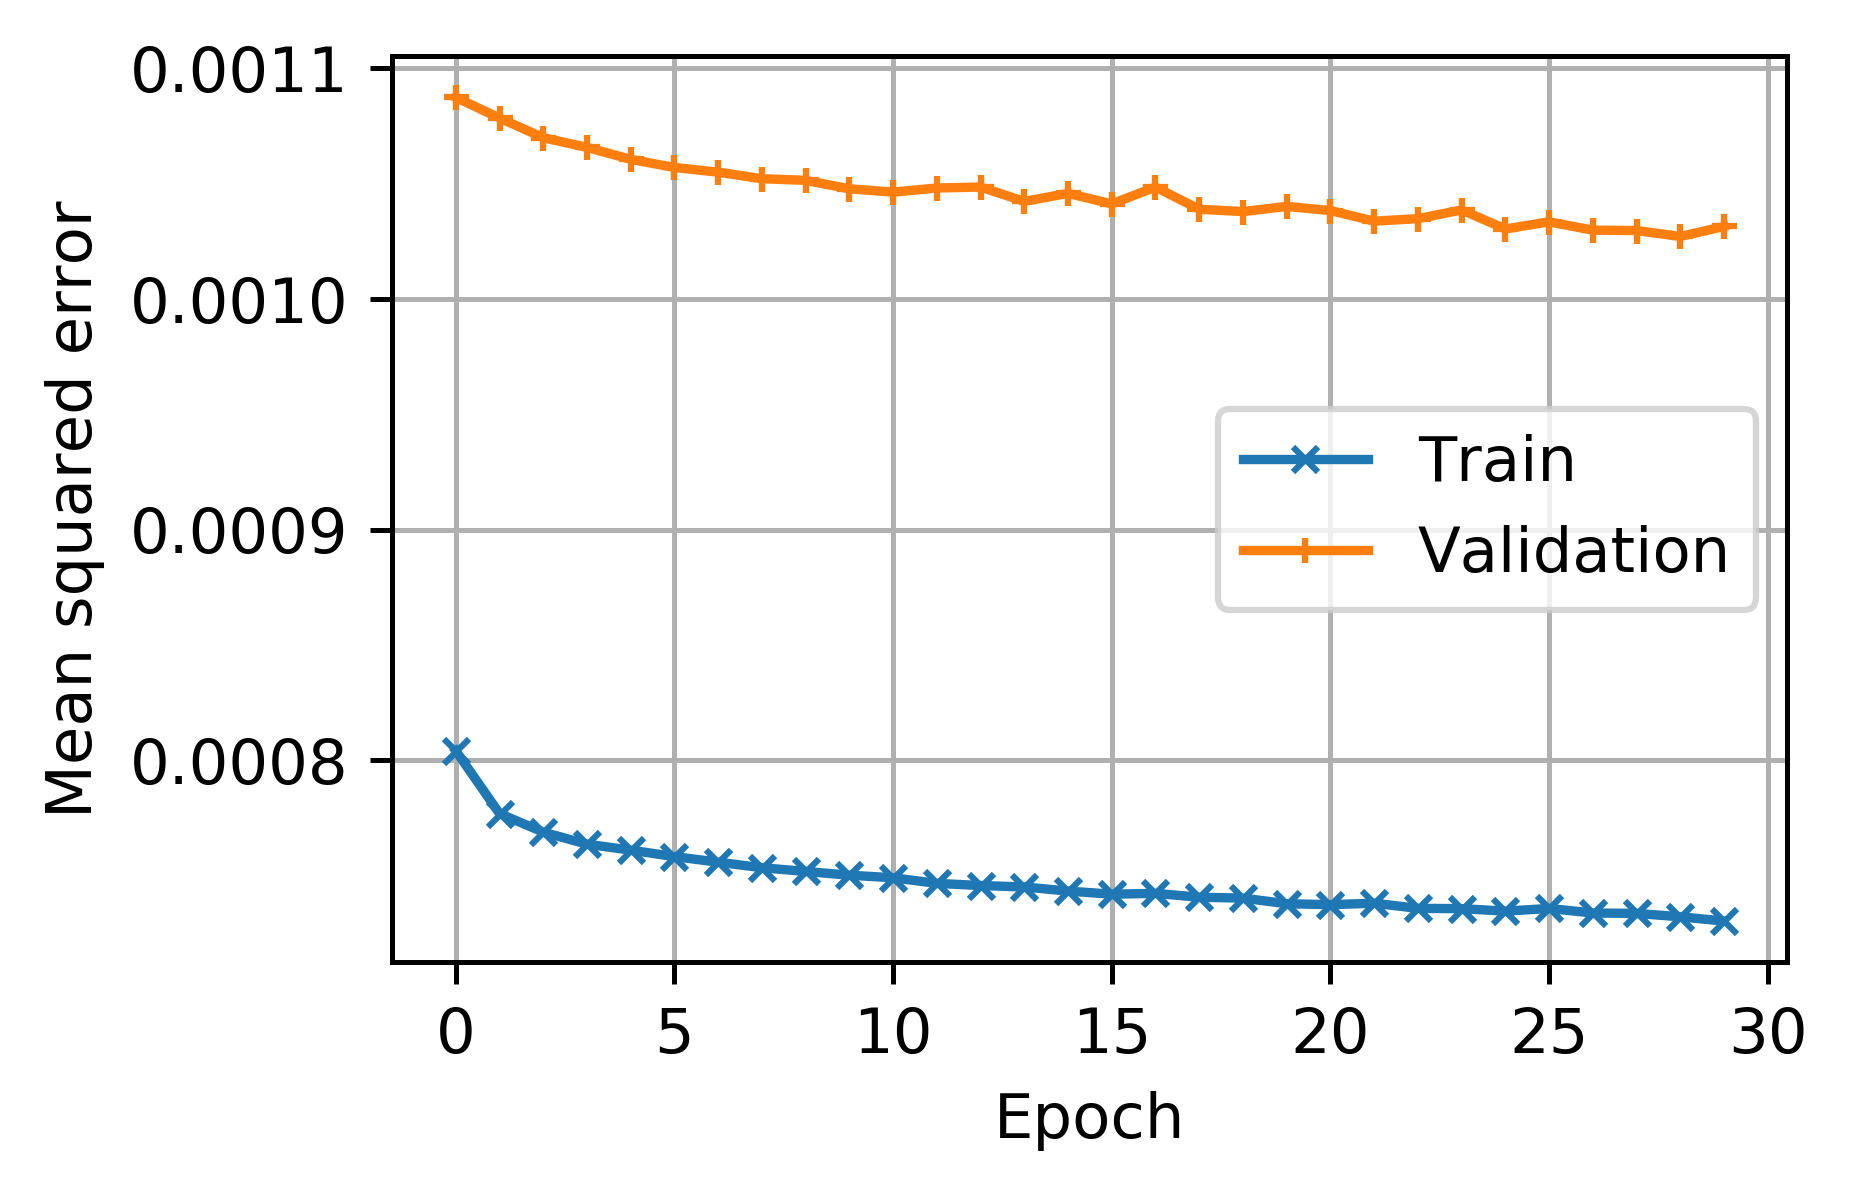

In [9]:
#Saving training history
np.save("../Data/loss_residual_unet_data_augmentation_compress_5.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_unet_data_augmentation_compress_5.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()